In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [207]:
def get_data():
    base_dir = "./usd_swap"
    df = None
    for i in [1, 2, 3, 4, 5, 7, 10, 30]:
        fn = os.path.join(base_dir, f"DSWP{i}.csv")
        print(fn)
        temp_df = pd.read_csv(fn, index_col="DATE", parse_dates=["DATE"], )
        if df is None:
            df = temp_df
        else:
            df = pd.merge(df, temp_df, left_index=True, right_index=True)
    df = df.replace(to_replace=".", value=pd.NA)
    df = df.dropna()
    df = df.astype(float)
    df = df[(df.index >= pd.to_datetime("2001-10-01")) & (df.index <= pd.to_datetime("2008-10-02"))]
    print(df)
    return df



In [283]:
def plot_data(df):
    df.plot(title="USD Swap Curve")
    plt.show()

    df.boxplot()
    plt.title("USD Swap Rate boxplot")
    plt.show()



def pca(df):
    scaler = StandardScaler().fit(df)
    res_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    res_df.dropna(how='any', inplace=True)
    print(f"rescaled df {res_df}")


    res_df.plot(title="rescaled data")
    plt.show()
    pc = PCA().fit(res_df)
    print(f"eigenvalues {pc.explained_variance_}, \neigenvectors {pc.components_} ")
    num_eigen = 3
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    Series1 = pd.Series(pc.explained_variance_ratio_[:num_eigen]).sort_values()
    Series2 = pd.Series(pc.explained_variance_ratio_[:num_eigen]).cumsum()
    Series1.plot.barh(title='Explained Variance Ratio by Top Factors', ax=axes[0])
    Series2.plot(ylim=(0, 1), ax=axes[1], title='Cumulative Explained Variance')
    plt.show()

    # compute using covariance method
    cov_matrix = res_df.cov()
    print(cov_matrix)
    plt.imshow(cov_matrix)
    plt.title("covariance matrix")
    plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns)
    plt.yticks(range(len(cov_matrix.index)), cov_matrix.index)
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.show()
    
    # Eigendecomposition
    eigen_val, eigen_vec = np.linalg.eig(cov_matrix)
    idx = eigen_val.argsort()[::-1]
    eigen_val = eigen_val[idx]
    eigen_vec = eigen_vec[:, idx]
    pc_val = eigen_val
    pc_vec = eigen_vec.T
    pc_exp = eigen_val / np.sum(eigen_val)
    print(pc_val)
    print(pc_vec)
    print(pc_exp)
    print(cov_matrix - eigen_vec @ np.diag(eigen_val) @ eigen_vec.T)
    print(cov_matrix - pc.components_.T @ np.diag(pc.explained_variance_) @ pc.components_)

    # empirical studies reveal that more than 99% of the movement of various U.S. Treasury bond yields
    # are captured by three factors, which are often referred to as level, slope, and curvature.
    pc_main = pd.DataFrame(pc.components_[:3, :].T, index=df.columns, columns=["PC1", "PC2", "PC3"])
    eigen_main = pc.explained_variance_[:3]

    pc_main = pc_main.apply(lambda x: x*np.sqrt(eigen_main), axis=1)
    pc_main.plot(style=['s-', 'o-', '^-'], title="Principal Component")
    plt.show()

    print(f"principal component {pc_main}")
    vol = pc_main.apply(lambda x: np.sqrt((x*x).sum()), axis=1).to_frame(name="pc_vol")
    print(f"vol is {vol}")
    vol["total_vol"] = res_df.std()
    vol["PC Vol / Total Vol %"] = vol["pc_vol"]/vol["total_vol"]

    print(f"volatility {vol}")

    stat_df = pd.merge(pc_main, vol, left_index=True, right_index=True)

    pc_vol_ratio = pc_main.apply(lambda x: (x*x)/(x*x).sum(), axis=1)
    pc_vol_ratio = pc_vol_ratio.rename(columns={"PC1": "PC1_VAR%", "PC2": "PC2_VAR%", "PC3": "PC3_VAR%"})

    stat_df = pd.merge(stat_df, pc_vol_ratio, left_index=True, right_index=True)
    print(f"stat_df {stat_df}")

    # eigen factor
    pc_factor = df @ pc_main
    pc_factor.plot(title="eigenfactor values")
    plt.show()
    return pc_main, eigen_main, stat_df

    



In [284]:
df = get_data()

./usd_swap/DSWP1.csv
./usd_swap/DSWP2.csv
./usd_swap/DSWP3.csv
./usd_swap/DSWP4.csv
./usd_swap/DSWP5.csv
./usd_swap/DSWP7.csv
./usd_swap/DSWP10.csv
./usd_swap/DSWP30.csv
            DSWP1  DSWP2  DSWP3  DSWP4  DSWP5  DSWP7  DSWP10  DSWP30
DATE                                                                
2001-10-01   2.68   3.35   3.89   4.27   4.54   4.92    5.25    5.92
2001-10-02   2.66   3.33   3.87   4.25   4.53   4.89    5.21    5.84
2001-10-03   2.55   3.21   3.77   4.17   4.44   4.82    5.15    5.75
2001-10-04   2.56   3.23   3.81   4.20   4.47   4.83    5.15    5.79
2001-10-05   2.50   3.17   3.77   4.17   4.46   4.84    5.17    5.79
...           ...    ...    ...    ...    ...    ...     ...     ...
2008-09-26   3.35   3.48   3.79   3.99   4.11   4.32    4.50    4.76
2008-09-29   3.13   3.24   3.56   3.76   3.91   4.13    4.32    4.58
2008-09-30   3.33   3.36   3.64   3.84   3.98   4.19    4.37    4.60
2008-10-01   3.26   3.33   3.61   3.81   3.95   4.16    4.34    4.54
20

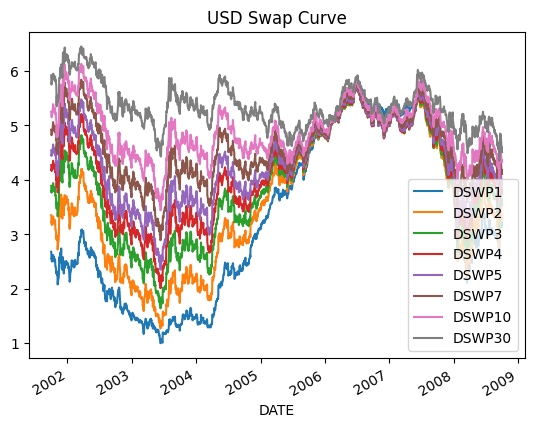

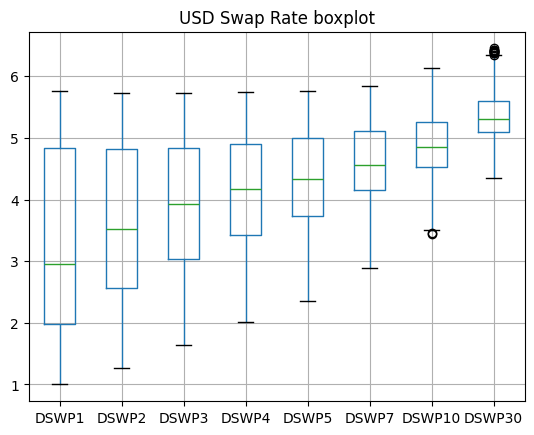

In [285]:
plot_data(df)

rescaled df                DSWP1     DSWP2     DSWP3     DSWP4     DSWP5     DSWP7  \
DATE                                                                     
2001-10-01 -0.405243 -0.212473 -0.013995  0.150516  0.276282  0.496661   
2001-10-02 -0.418692 -0.229063 -0.034042  0.127027  0.262842  0.446997   
2001-10-03 -0.492658 -0.328598 -0.134277  0.033071  0.141884  0.331114   
2001-10-04 -0.485934 -0.312009 -0.094183  0.068304  0.182203  0.347669   
2001-10-05 -0.526279 -0.361777 -0.134277  0.033071  0.168764  0.364223   
...              ...       ...       ...       ...       ...       ...   
2008-09-26  0.045279 -0.104643 -0.114230 -0.178331 -0.301629 -0.496623   
2008-09-29 -0.102654 -0.303714 -0.344769 -0.448454 -0.570425 -0.811164   
2008-09-30  0.031831 -0.204179 -0.264581 -0.354498 -0.476346 -0.711835   
2008-10-01 -0.015239 -0.229063 -0.294652 -0.389732 -0.516666 -0.761499   
2008-10-02 -0.042136 -0.295420 -0.374839 -0.471943 -0.583865 -0.844273   

              DSWP10    D

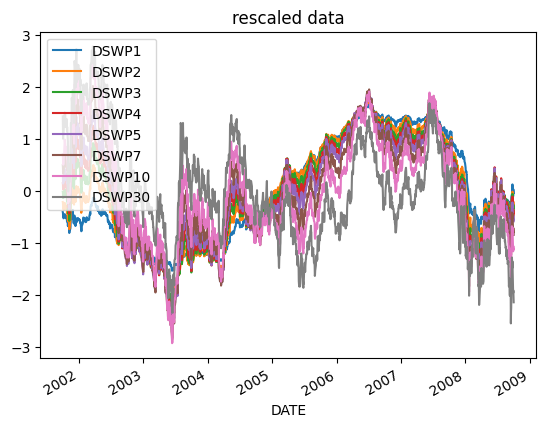

eigenvalues [6.57519546e+00 1.38958288e+00 3.29987099e-02 6.00238712e-03
 5.52700337e-04 1.39782725e-04 6.91667170e-05 2.25165835e-05], 
eigenvectors [[ 0.33447374  0.36441077  0.38025733  0.3876834   0.3894345   0.38036037
   0.34855477  0.20643254]
 [-0.4233409  -0.30050054 -0.18651212 -0.08353559  0.01301653  0.18292156
   0.37913114  0.71508517]
 [ 0.67134206  0.17201576 -0.12819705 -0.26456727 -0.3009388  -0.25592419
  -0.08241277  0.52002585]
 [ 0.41604798 -0.36103066 -0.3870284  -0.2073739   0.00626938  0.30951301
   0.51226155 -0.38146629]
 [-0.24536644  0.49058018  0.15414018 -0.1749885  -0.45622498 -0.21815229
   0.59925169 -0.17295079]
 [-0.15355408  0.54975687 -0.35992482 -0.51926665  0.30891341  0.371585
  -0.20359456 -0.00715149]
 [-0.00256578 -0.05196053  0.24736892 -0.01011955 -0.63146367  0.68798657
  -0.25266299  0.00944767]
 [ 0.03638128 -0.26715206  0.66324632 -0.65525749  0.23505908 -0.03973474
   0.03425607 -0.00655916]] 


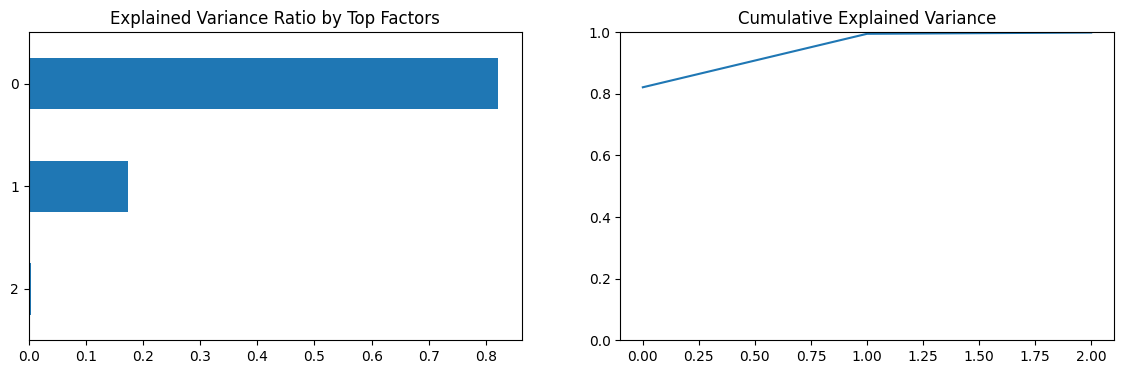

           DSWP1     DSWP2     DSWP3     DSWP4     DSWP5     DSWP7    DSWP10  \
DSWP1   1.000570  0.981028  0.942173  0.895402  0.842203  0.724018  0.542898   
DSWP2   0.981028  1.000570  0.989126  0.962664  0.925857  0.832832  0.675418   
DSWP3   0.942173  0.989126  1.000570  0.992564  0.971513  0.903931  0.772435   
DSWP4   0.895402  0.962664  0.992564  1.000570  0.993832  0.950184  0.844528   
DSWP5   0.842203  0.925857  0.971513  0.993832  1.000570  0.979856  0.900059   
DSWP7   0.724018  0.832832  0.903931  0.950184  0.979856  1.000570  0.969638   
DSWP10  0.542898  0.675418  0.772435  0.844528  0.900059  0.969638  1.000570   
DSWP30  0.043923  0.199760  0.329477  0.439161  0.536391  0.692960  0.847192   

          DSWP30  
DSWP1   0.043923  
DSWP2   0.199760  
DSWP3   0.329477  
DSWP4   0.439161  
DSWP5   0.536391  
DSWP7   0.692960  
DSWP10  0.847192  
DSWP30  1.000570  


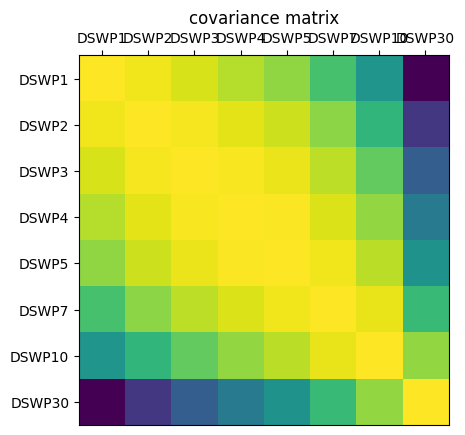

[6.57519546e+00 1.38958288e+00 3.29987099e-02 6.00238712e-03
 5.52700337e-04 1.39782725e-04 6.91667170e-05 2.25165835e-05]
[[ 0.33447374  0.36441077  0.38025733  0.3876834   0.3894345   0.38036037
   0.34855477  0.20643254]
 [-0.4233409  -0.30050054 -0.18651212 -0.08353559  0.01301653  0.18292156
   0.37913114  0.71508517]
 [-0.67134206 -0.17201576  0.12819705  0.26456727  0.3009388   0.25592419
   0.08241277 -0.52002585]
 [ 0.41604798 -0.36103066 -0.3870284  -0.2073739   0.00626938  0.30951301
   0.51226155 -0.38146629]
 [-0.24536644  0.49058018  0.15414018 -0.1749885  -0.45622498 -0.21815229
   0.59925169 -0.17295079]
 [-0.15355408  0.54975687 -0.35992482 -0.51926665  0.30891341  0.371585
  -0.20359456 -0.00715149]
 [-0.00256578 -0.05196053  0.24736892 -0.01011955 -0.63146367  0.68798657
  -0.25266299  0.00944767]
 [-0.03638128  0.26715206 -0.66324632  0.65525749 -0.23505908  0.03973474
  -0.03425607  0.00655916]]
[8.21430847e-01 1.73598831e-01 4.12248706e-03 7.49870626e-04
 6.904815

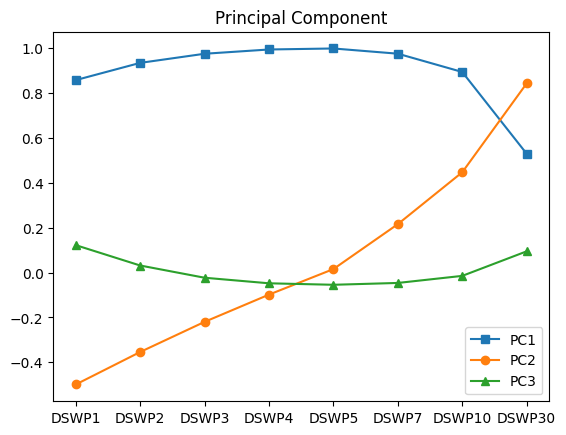

principal component              PC1       PC2       PC3
DSWP1   0.857662 -0.499037  0.121953
DSWP2   0.934427 -0.354232  0.031248
DSWP3   0.975061 -0.219862 -0.023288
DSWP4   0.994103 -0.098472 -0.048060
DSWP5   0.998594  0.015344 -0.054667
DSWP7   0.975326  0.215629 -0.046490
DSWP10  0.893769  0.446922 -0.014971
DSWP30  0.529337  0.842946  0.094466
vol is           pc_vol
DSWP1   0.999747
DSWP2   0.999805
DSWP3   0.999813
DSWP4   1.000124
DSWP5   1.000206
DSWP7   0.999959
DSWP10  0.999393
DSWP30  0.999840
volatility           pc_vol  total_vol  PC Vol / Total Vol %
DSWP1   0.999747   1.000285              0.999462
DSWP2   0.999805   1.000285              0.999520
DSWP3   0.999813   1.000285              0.999528
DSWP4   1.000124   1.000285              0.999839
DSWP5   1.000206   1.000285              0.999921
DSWP7   0.999959   1.000285              0.999673
DSWP10  0.999393   1.000285              0.999108
DSWP30  0.999840   1.000285              0.999555
stat_df              PC1  

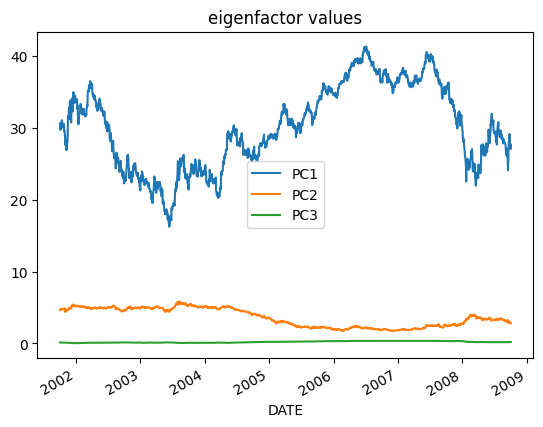

In [286]:
pc_main, eigen_main, stat_df = pca(df)

In [287]:
stat_df

,PC1,PC2,PC3,pc_vol,total_vol,PC Vol / Total Vol %,PC1_VAR%,PC2_VAR%,PC3_VAR%
DSWP1,0.857662,-0.499037,0.121953,0.999747,1.000285,0.999462,0.735957,0.249163,0.014880
DSWP2,0.934427,-0.354232,0.031248,0.999805,1.000285,0.999520,0.873494,0.125529,0.000977
DSWP3,0.975061,-0.219862,-0.023288,0.999813,1.000285,0.999528,0.951100,0.048357,0.000543
DSWP4,0.994103,-0.098472,-0.048060,1.000124,1.000285,0.999839,0.987996,0.009694,0.002309
DSWP5,0.998594,0.015344,-0.054667,1.000206,1.000285,0.999921,0.996777,0.000235,0.002987
DSWP7,0.975326,0.215629,-0.046490,0.999959,1.000285,0.999673,0.951339,0.046500,0.002162
DSWP10,0.893769,0.446922,-0.014971,0.999393,1.000285,0.999108,0.799794,0.199982,0.000224
DSWP30,0.529337,0.842946,0.094466,0.999840,1.000285,0.999555,0.280288,0.710786,0.008927
